In [1]:
import os
from google_play_scraper import Sort, reviews
import pandas as pd
from tqdm import tqdm
from langdetect import detect
from deep_translator import GoogleTranslator
from transformers import pipeline
import os
import time
from langdetect.lang_detect_exception import LangDetectException

from collections import Counter

d:\kaimtenx\week22\bank-review-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

In [3]:
tqdm.pandas()

# Load your cleaned translated dataset
df = pd.read_csv("../data/translated_allbanksdata_cleaned.csv")

# Load HuggingFace sentiment classifier
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Sentiment classification with neutral
def classify_sentiment(text):
    result = classifier(text[:512])[0]  # Truncate to 512 tokens
    label = result["label"]
    score = result["score"]

    if score < 0.6:
        return "neutral", score
    elif label == "POSITIVE":
        return "positive", score
    else:
        return "negative", score

# Detect language
def detect_language(text):
    try:
        return detect(str(text))
    except LangDetectException:
        return 'unknown'

# Detect and display language distribution
print("🔍 Detecting languages...")
df['lang_detected'] = df['translated_review'].progress_apply(detect_language)

lang_counts = Counter(df['lang_detected'])
print("\n🌐 Language Distribution in translated_review:")
for lang, count in lang_counts.items():
    print(f"{lang}: {count} reviews")

# Apply sentiment analysis
print("🔍 Classifying sentiment...")
sentiment_results = df['translated_review'].progress_apply(classify_sentiment)
df['sentiment_label'] = sentiment_results.apply(lambda x: x[0])
df['sentiment_score'] = sentiment_results.apply(lambda x: x[1])

# Save result
df.to_csv("../data/sentiment_allbanksdata.csv", index=False)
print("✅ Saved sentiment results to: ../data/sentiment_allbanksdata.csv")

Device set to use cpu


🔍 Detecting languages...


100%|██████████| 1175/1175 [00:04<00:00, 274.03it/s]



🌐 Language Distribution in translated_review:
en: 1171 reviews
af: 3 reviews
cy: 1 reviews
🔍 Classifying sentiment...


100%|██████████| 1175/1175 [00:41<00:00, 28.36it/s]

✅ Saved sentiment results to: ../data/sentiment_allbanksdata.csv


In [4]:
# Load the sentiment dataset
df = pd.read_csv("../data/sentiment_allbanksdata.csv")

# Keep only rows where language is 'en'
df = df[df['lang_detected'] == 'en']

# Save the ../cleaned dataset
df.to_csv("../data/sentiment_allbanksdata_en_only.csv", index=False)
print(f" English-only reviews saved to: ..data/sentiment_allbanksdata_English.csv")

 English-only reviews saved to: ..data/sentiment_allbanksdata_English.csv


In [5]:
# Load cleaned data
df = pd.read_csv("../data/sentiment_allbanksdata_en_only.csv")

# Load sentiment analysis model
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def classify_sentiment(text):
    result = classifier(text[:512])[0]  # Limit to 512 tokens
    label = result['label']
    score = result['score']
    if score < 0.6:
        return 'NEUTRAL', score
    return label, score

# Apply sentiment analysis
tqdm.pandas()
df[['sentiment_label', 'sentiment_score']] = df['review'].progress_apply(
    lambda x: pd.Series(classify_sentiment(str(x)))
)

# Save with sentiment
df.to_csv("../data/reviews_with_sentimentfinal.csv", index=False)

Device set to use cpu
100%|██████████| 1171/1171 [00:27<00:00, 43.11it/s]


In [6]:
# Load sentiment-labeled data
df = pd.read_csv("../data/reviews_with_sentimentfinal.csv")

# Mean sentiment score per bank
print("\n📈 Average Sentiment Score by Bank:")
print(df.groupby('bank')['sentiment_score'].mean().round(3))

# Mean sentiment by bank + rating
print("\n📊 Average Sentiment Score by Bank and Rating:")
print(df.groupby(['bank', 'rating'])['sentiment_score'].mean().round(3))

# Optional: Count of sentiment types per bank
print("\n🔢 Sentiment label count by bank:")
print(df.groupby(['bank', 'sentiment_label']).size())


📈 Average Sentiment Score by Bank:
bank
Absiniya    0.984
Cbe         0.985
Dashin      0.992
Name: sentiment_score, dtype: float64

📊 Average Sentiment Score by Bank and Rating:
bank      rating
Absiniya  1         0.989
          2         0.965
          3         0.983
          4         0.963
          5         0.978
Cbe       1         0.994
          2         0.998
          3         0.987
          4         0.956
          5         0.985
Dashin    1         0.999
          2         0.986
          3         0.997
          4         0.995
          5         0.992
Name: sentiment_score, dtype: float64

🔢 Sentiment label count by bank:
bank      sentiment_label
Absiniya  NEGATIVE           321
          NEUTRAL              3
          POSITIVE           112
Cbe       NEGATIVE           195
          NEUTRAL              1
          POSITIVE           233
Dashin    NEGATIVE            70
          POSITIVE           236
dtype: int64


In [7]:
# Optional: Ensure rating column is numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating', 'sentiment_score'])

# Group by bank and rating, then compute average sentiment score
agg = df.groupby(['bank', 'rating'])['sentiment_score'].mean().reset_index()

# Save aggregated results
agg.to_csv("../data/sentiment_aggregates_by_bank_rating.csv", index=False)

print("✅ Aggregated sentiment by bank and rating saved.")
pivot = agg.pivot(index='bank', columns='rating', values='sentiment_score')
pivot.to_csv("../data/sentiment_pivot_table.csv")

✅ Aggregated sentiment by bank and rating saved.


In [8]:
agg = pd.read_csv("../data/sentiment_aggregates_by_bank_rating.csv")
pivot = pd.read_csv("../data/sentiment_pivot_table.csv")

print("\n=== Aggregated Sentiment by Bank and Rating ===\n")
print(agg)

print("\n=== Pivot Table Format ===\n")
print(pivot)


=== Aggregated Sentiment by Bank and Rating ===

        bank  rating  sentiment_score
0   Absiniya       1         0.989370
1   Absiniya       2         0.964561
2   Absiniya       3         0.983056
3   Absiniya       4         0.963430
4   Absiniya       5         0.977867
5        Cbe       1         0.994166
6        Cbe       2         0.998415
7        Cbe       3         0.986878
8        Cbe       4         0.956228
9        Cbe       5         0.984998
10    Dashin       1         0.998587
11    Dashin       2         0.986041
12    Dashin       3         0.997215
13    Dashin       4         0.994640
14    Dashin       5         0.991836

=== Pivot Table Format ===

       bank         1         2         3         4         5
0  Absiniya  0.989370  0.964561  0.983056  0.963430  0.977867
1       Cbe  0.994166  0.998415  0.986878  0.956228  0.984998
2    Dashin  0.998587  0.986041  0.997215  0.994640  0.991836


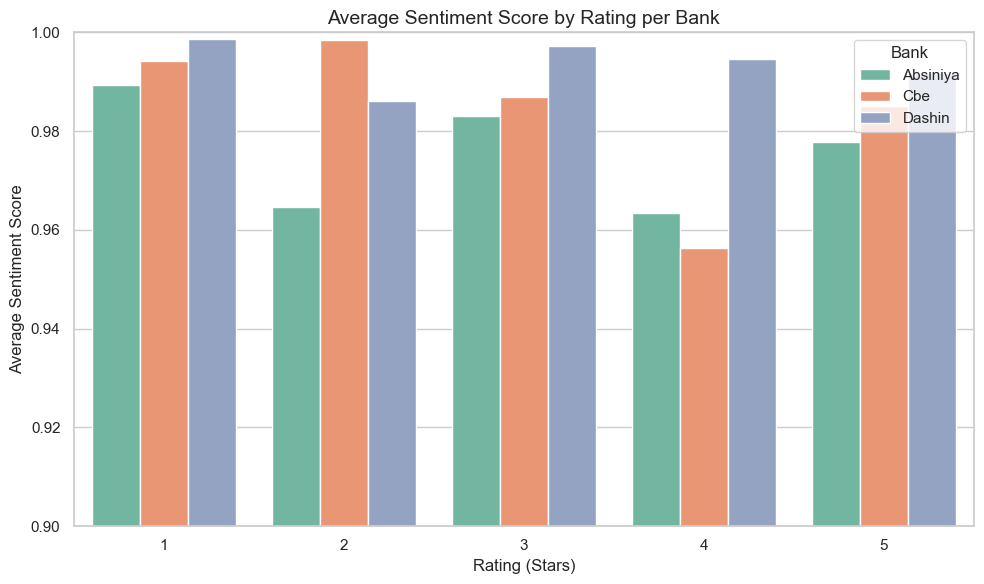

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Load aggregated data
df = pd.read_csv("../data/sentiment_aggregates_by_bank_rating.csv")

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="rating",
    y="sentiment_score",
    hue="bank",
    palette="Set2"
)

# Customize labels and title
plt.title("Average Sentiment Score by Rating per Bank", fontsize=14)
plt.xlabel("Rating (Stars)", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.ylim(0.9, 1.0)  # Adjust for zoom if sentiment scores are close together
plt.legend(title="Bank")
plt.tight_layout()

# Save the plot
plt.savefig("../data/sentiment_by_rating_barplot.png", dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

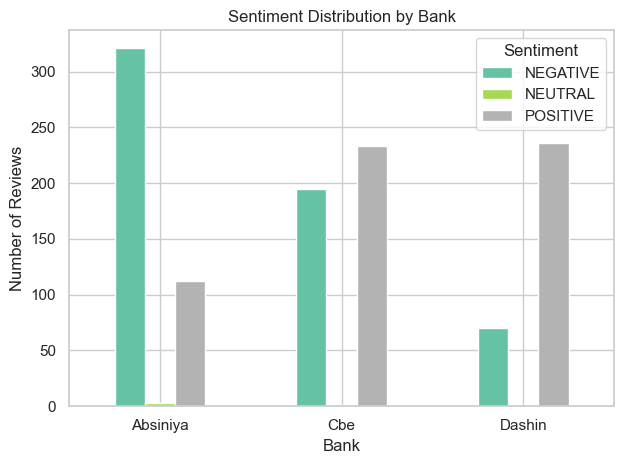

In [12]:
df = pd.read_csv("../data/reviews_with_sentimentfinal.csv")
# Count of sentiments by bank
sentiment_counts = df.groupby(['bank', 'sentiment_label']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', stacked=False, colormap='Set2')
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig("../data/plot_sentiment_by_bank.png")
plt.show()

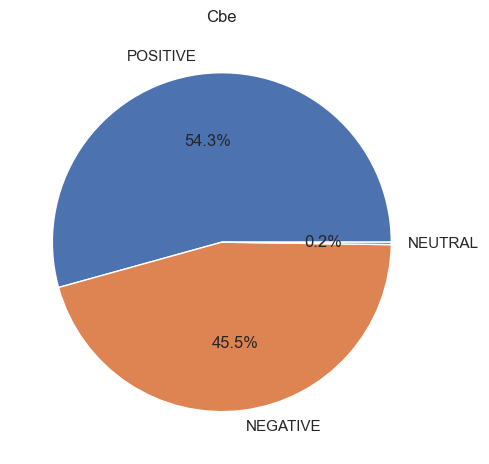

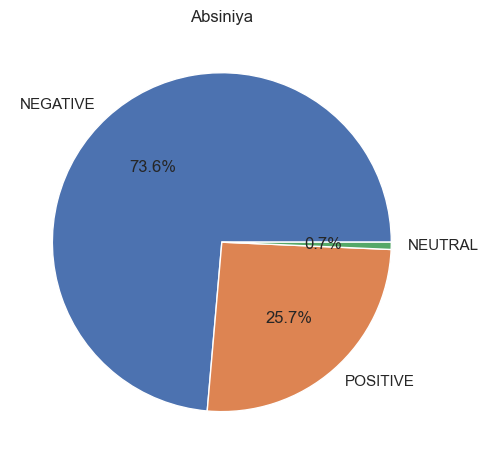

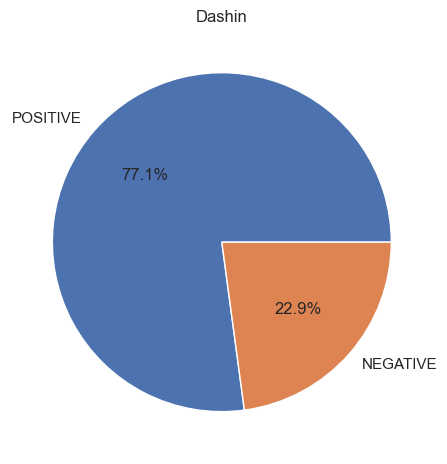

In [14]:
for bank in df['bank'].unique():
    counts = df[df['bank'] == bank]['sentiment_label'].value_counts()
    counts.plot.pie(autopct='%1.1f%%', title=bank)
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(f"../data/sentiment_pie_{bank}.png")
    plt.show()

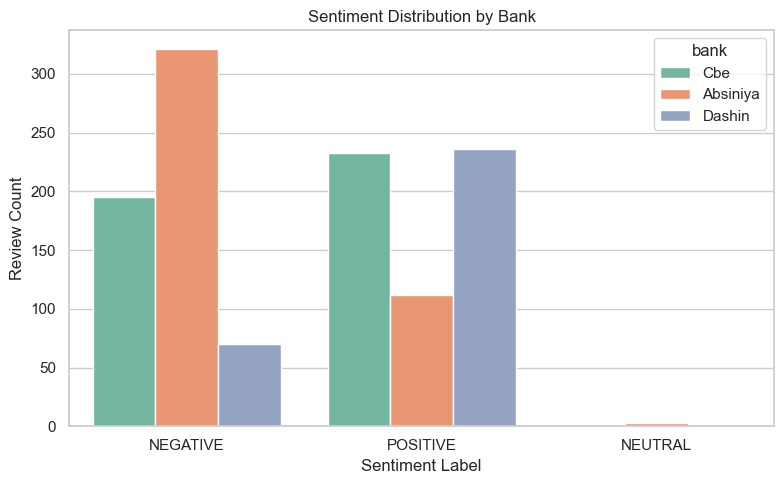

In [15]:
df = pd.read_csv("../data/reviews_with_sentimentfinal.csv")

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment_label", hue="bank", palette="Set2")
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Sentiment Label")
plt.ylabel("Review Count")
plt.tight_layout()
plt.savefig("../data/sentiment_distribution.png", dpi=300)
plt.show()

In [17]:
from wordcloud import WordCloud

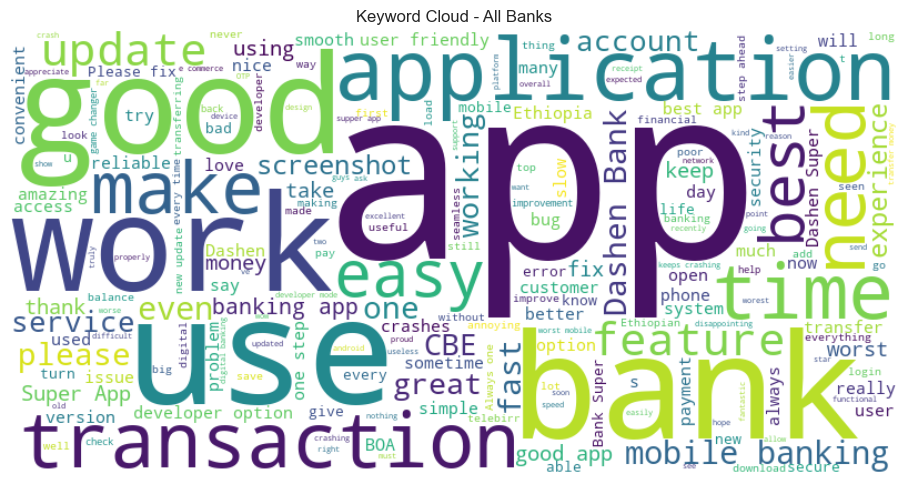

In [18]:
# Combine all reviews
text = " ".join(df["review"].astype(str).tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Keyword Cloud - All Banks")
plt.tight_layout()
plt.savefig("../data/keyword_cloud.png", dpi=300)
plt.show()

In [ ]:
# Create output directory if it doesn't exist
output_dir = "../data/keyword_clouds"
os.makedirs(output_dir, exist_ok=True)

# Loop through each bank
for bank in df['bank'].unique():
    bank_df = df[df['bank'] == bank]
    text = " ".join(bank_df['review'].astype(str).tolist())

    # Generate WordCloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Set2',
        max_words=100
    ).generate(text)

    # Plot and save
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Keyword Cloud - {bank}")
    plt.tight_layout()
    output_path = f"{output_dir}/{bank.lower().replace(' ', '_')}_wordcloud.png"
    plt.savefig(output_path, dpi=300)
    plt.close()
   

    print(f" Saved: {output_path}")
    plt.show()

⚠️ No positive reviews found for Cbe. Skipping.
⚠️ No positive reviews found for Absiniya. Skipping.
⚠️ No positive reviews found for Dashin. Skipping.


In [33]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer 

In [36]:
#Thematic Analysis Pipeline
df = pd.read_csv("../data/reviews_with_sentimentfinal.csv")
nlp = spacy.load("en_core_web_sm")

# Step 1: Preprocessing (tokenization, stop-word removal, lemmatization)
def preprocess(text):
    doc = nlp(str(text).lower())
    return " ".join([
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ])

df["cleaned_review"] = df["review"].apply(preprocess)

# Step 2: Keyword extraction using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
X = vectorizer.fit_transform(df["cleaned_review"])
keywords = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1

tfidf = pd.DataFrame({"keyword": keywords, "score": scores})
tfidf.sort_values("score", ascending=False).to_csv("../data/tfidf_keywords.csv", index=False)

# Step 3: Manual Theme Mapping
theme_keywords = {
    "Account Access Issues": ["login", "password", "authentication"],
    "Transaction Performance": ["transfer", "delay", "fail", "processing"],
    "User Interface & Experience": ["design", "interface", "navigation"],
    "Customer Support": ["support", "response", "call"],
    "Feature Requests": ["fingerprint", "dark mode", "update", "budget"]
}

def assign_theme(text):
    themes = []
    for theme, keys in theme_keywords.items():
        if any(k in text for k in keys):
            themes.append(theme)
    return ", ".join(themes) if themes else "Other"

df["themes"] = df["cleaned_review"].apply(assign_theme)
df.to_csv("../data/reviews_with_themes.csv", index=False)
print("✅ Saved: reviews_with_themes.csv")

✅ Saved: reviews_with_themes.csv


C:\Users\ayish\AppData\Local\Temp\ipykernel_16856\2999694573.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=theme_counts, x="Count", y="Theme", palette="muted")


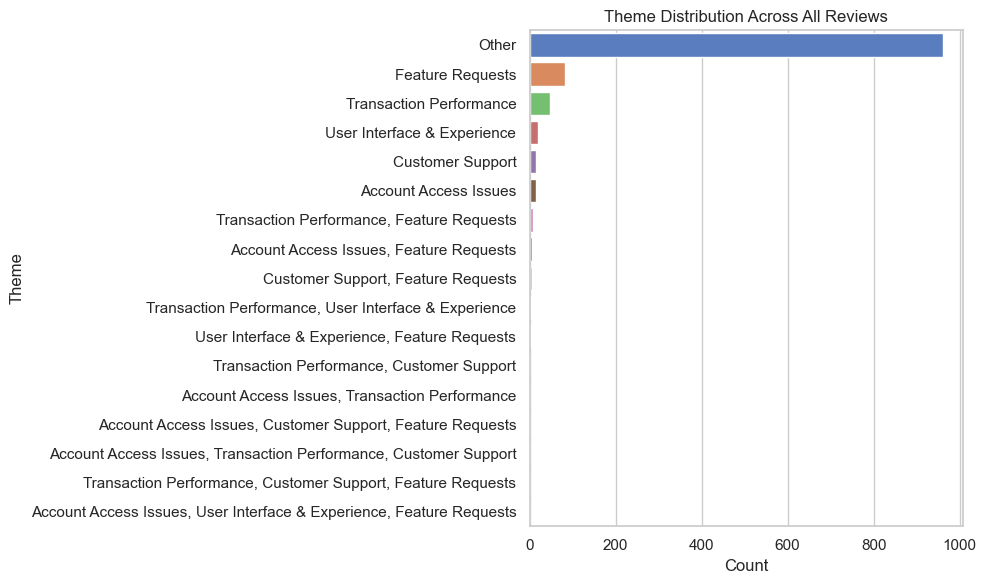

In [37]:
df = pd.read_csv("../data/reviews_with_themes.csv")

theme_counts = df['themes'].value_counts().reset_index()
theme_counts.columns = ['Theme', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=theme_counts, x="Count", y="Theme", palette="muted")
plt.title("Theme Distribution Across All Reviews")
plt.tight_layout()
plt.savefig("../data/theme_distribution.png", dpi=300)
plt.show()